In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [3]:
data_c1 = pd.read_csv(r"data\Classification\LS_Group24\Class1.txt", sep=" ", names=['f1', 'f2']) # 500
data_c2 = pd.read_csv(r"data\Classification\LS_Group24\Class2.txt", sep=" ", names=['f1', 'f2']) # 500
data_c3 = pd.read_csv(r"data\Classification\LS_Group24\Class3.txt", sep=" ", names=['f1', 'f2']) # 500
data_c1.insert(loc=0, column='1', value=[1 for i in range(len(data_c1))])
data_c2.insert(loc=0, column='1', value=[1 for i in range(len(data_c2))])
data_c3.insert(loc=0, column='1', value=[1 for i in range(len(data_c3))])
data_c1.insert(loc=3, column='y', value=[0 for i in range(len(data_c1))])
data_c2.insert(loc=3, column='y', value=[1 for i in range(len(data_c2))])
data_c3.insert(loc=3, column='y', value=[2 for i in range(len(data_c3))])

train_c1 = data_c1.iloc[:300, :] # 300
train_c2 = data_c2.iloc[:300, :] # 300
train_c3 = data_c3.iloc[:300, :] # 300

val_c1 = data_c1.iloc[300:400, :] # 100
val_c2 = data_c2.iloc[300:400, :] # 100
val_c3 = data_c3.iloc[300:400, :] # 100

test_c1 = data_c1.iloc[400:, :] # 100
test_c2 = data_c2.iloc[400:, :] # 100
test_c3 = data_c3.iloc[400:, :] # 100

train = pd.concat([train_c1, train_c2, train_c3], ignore_index=True).sample(frac=1).reset_index(drop=True)
val = pd.concat([val_c1, val_c2, val_c3], ignore_index=True).sample(frac=1).reset_index(drop=True)
test = pd.concat([test_c1, test_c2, test_c3], ignore_index=True).sample(frac=1).reset_index(drop=True)

In [4]:
class oneL_nn:
    
    def __init__(self, layer_sizes, learning_rate, num_epochs):
        self.input_size = layer_sizes[0]
        self.h1 = layer_sizes[1]
        self.k = layer_sizes[-1]
        self.params = self.initialize_params()
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def sigmoid(self, z):
        return 1/(1 + np.exp(-z))

    def loss(self, y, s):
        return np.square(y - s)/2 

    def initialize_params(self):
        params = dict()
        params['W1'] = np.random.randn(self.h1, self.input_size)
        params['W2'] = np.random.randn(self.k, self.h1+1)
        return params

    def forward(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        cache = dict()
        cache['A1'] = np.dot(W1, x) # j x 1
        cache['H1'] = self.sigmoid(cache['A1']) # j x 1
        cache['H1'] = np.append([[1]], cache['H1'], axis=0) # j+1 x 1
        cache['A2'] = np.dot(W2, cache['H1']) # k x 1
        cache['H2'] = self.sigmoid(cache['A2']) # k x 1
        return cache['H2'], cache

    def backward(self, x, y):
        s, cache = self.forward(x)

        dell2 = (y - s) * s * (1 - s) # k x 1
        dW2 = self.learning_rate * np.dot(dell2, cache['H1'].T) # k x j+1
        self.params['W2'] = self.params['W2'] + dW2 # k x j+1

        dell1 = np.dot(self.params['W2'][:, :-1].T, dell2) * cache['H1'][1:] * (1 - cache['H1'][1:]) # j x 1
        dW1 = self.learning_rate * np.dot(dell1, x.T) # j x m
        self.params['W1'] = self.params['W1'] + dW1 # j x m
    
        return self.loss(y, s)

    def epoch(self, train):
        E = []
        for i in range(train.shape[0]):
            y = np.zeros((self.k, 1))
            y[train['y'][i]][0] = 1
            x = np.array(train.iloc[i, :-1]).reshape((self.input_size, 1))
            e = self.backward(x, y)
            E.append(e)

        return np.mean(E)

    def fit(self, train):
        history = []
        for i in range(1, self.num_epochs + 1):
            E = self.epoch(train)
            history.append(E)
        return history
    
    def predict(self, test):
        preds = np.zeros(test.shape[0])
        for i in range(test.shape[0]):
            pred, _ = self.forward(np.array(test.iloc[i, :-1]).reshape((3, 1)))
            preds[i] = np.argmax(pred)
        return preds

In [5]:
input_size = 3
layer_sizes = [3, 8, 3]
learning_rate, num_epochs = 0.1, 50 
model = oneL_nn(layer_sizes, learning_rate, num_epochs)

history = model.fit(train)

In [9]:
x = np.linspace(-10, 12, 200)
y = np.linspace(-25, 7, 200)
xm, ym = np.meshgrid(x, y)
mesh = pd.DataFrame()
mesh['1'] = [1 for i in range(40000)]
mesh['f1'] = xm.reshape((40000, 1))
mesh['f2'] = ym.reshape((40000, 1))
mesh['pred'] = [1 for i in range(40000)]
mesh['pred'] = model.predict(mesh).astype(int)

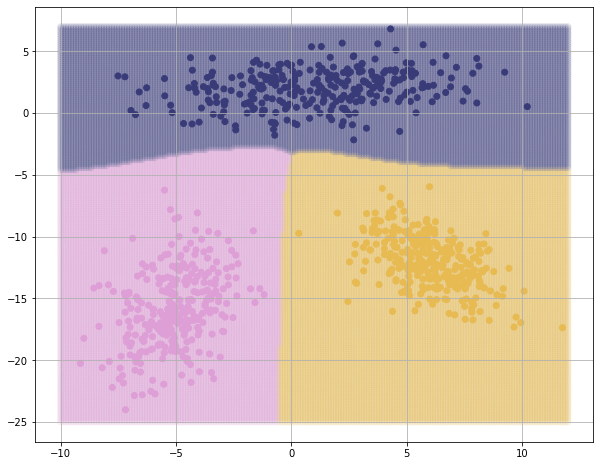

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
plt.scatter(mesh.f1, mesh.f2, c=mesh.pred, alpha=0.1, cmap='tab20b')
plt.scatter(train.f1, train.f2, c=train.y, cmap='tab20b')
plt.grid()

In [31]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def loss(y, s):
    return np.square(y - s)/2 

def initialize_params(input_size, h1, k):
    params = dict()
    params['W1'] = np.random.randn(h1, input_size)
    params['W2'] = np.random.randn(k, h1+1)
    return params

def forward(x, params):
    W1, W2 = params['W1'], params['W2']
    cache = dict()
    cache['A1'] = np.dot(W1, x)
    cache['H1'] = sigmoid(cache['A1'])
    cache['H1'] = np.append([[1]], cache['H1'], axis=0)
    cache['A2'] = np.dot(W2, cache['H1'])
    cache['H2'] = sigmoid(cache['A2'])
    return cache['H2'], cache

def backward(x, y, params, learning_rate):
    s, cache = forward(x, params)
    
    dell2 = (y - s) * s * (1 - s) # k x 1
    dW2 = learning_rate * np.dot(dell2, cache['H1'].T) # k x j
    params['W2'] = params['W2'] + dW2 # k x j
    
    dell1 = np.dot(params['W1'], dell2) * cache['H1'][1:] * (1 - cache['H1'][1:]) # j x 1
    dW1 = learning_rate * np.dot(dell1, x.T) # j x i
    params['W1'] = params['W1'] + dW1 # j x i
    
    return loss(y, s)

def epoch(X, k, params, learning_rate):
    E = []
    for i in range(X.shape[0]):
        y = np.zeros((k, 1))
        y[X['y'][i]][0] = 1
        x = np.array(X.iloc[i, :-1]).reshape((3, 1))
        e = backward(x, y, params, learning_rate)
        E.append(e)
        
    return np.mean(E)

def oneL_nn(X, num_epochs, input_size, h1, k, learning_rate):
    params = initialize_params(input_size, h1, k)
    avg_error = []
    for i in range(num_epochs):
        E = epoch(X, k, params, learning_rate)
        avg_error.append(E)
        
    return avg_error

history = oneL_nn(train, 100, 3, 16, 3, 0.001)

In [ ]:
p